In [ ]:
%matplotlib inline

import dask
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seawater as sw
import xarray as xr

# import hvplot.xarray

import dcpy
import pump

# import facetgrid

mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['savefig.bbox'] = 'tight'
mpl.rcParams['figure.dpi'] = 250

xr.set_options(keep_attrs=False)

import distributed
import dask_jobqueue

if 'client' in locals():
    client.close(); cluster.close()

cluster = dask_jobqueue.SLURMCluster(
    cores=1, processes=1, memory='25GB',
    walltime='02:00:00', project='NCGD0043')

client = dask.distributed.Client(cluster)

In [ ]:
cluster.adapt(minimum=2, maximum=24, wait_count=300)

In [ ]:
gcm1 = pump.model('../glade/TPOS_MITgcm_1_hb/HOLD/',
                  name='gcm1', full=True, budget=False)
gcm1.tao.load()

<xarray.Dataset>
Dimensions:          (depth: 284, latitude: 7, longitude: 6, time: 2947)
Coordinates:
  * latitude         (latitude) float64 -8.0 -5.0 -2.0 0.0 2.0 5.0 8.0
  * longitude        (longitude) float64 -170.0 -155.0 -140.0 ... -110.0 -95.0
  * depth            (depth) float32 -0.5 -1.5 -2.5 ... -458.8152 -479.7476
  * time             (time) datetime64[ns] 1995-09-01 ... 1997-01-04T12:00:00
Data variables:
    TOTTTEND         (time, depth, latitude, longitude) float32 -0.024368098 ... 0.0025818094
    ADVx_TH          (time, depth, latitude, longitude) float32 -30994.732 ... 50547.816
    ADVy_TH          (time, depth, latitude, longitude) float32 -10328.398 ... 10820.97
    ADVr_TH          (time, depth, latitude, longitude) float32 nan nan ... nan
    DFrI_TH          (time, depth, latitude, longitude) float32 nan ... -4.753581
    KPPg_TH          (time, depth, latitude, longitude) float32 nan nan ... nan
    WTHMASS          (time, depth, latitude, longitude) float32 

In [ ]:
gcm1.tiw_trange = [slice('1995-09-10', '1996-01-15'),
                   slice('1996-08-01', '1997-03-01')]

subset = gcm1.tao.sel(longitude=-140, latitude=0, drop=True)

subset['tiw_phase'] = gcm1.get_tiw_phase(subset.v.drop('period', errors='ignore'), debug=False)
subset['sst'] = gcm1.surface.theta.sel(longitude=-140, method='nearest')

slice('1995-09-10', '1996-01-15', None)
slice('1996-08-01', '1997-03-01', None)


/glade/u/home/dcherian/pump/pump/calc.py:362: UserWarning: Secondary peaks detected!
  warnings.warn("Secondary peaks detected!")


Let's overlay depth-averaged velocity between 10m and 80m with SST to make sure we have something reasonable.

In [ ]:
def set_concise_dates(ax):
    import matplotlib.dates as mdates

    locator = mdates.AutoDateLocator(minticks=3, maxticks=7)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

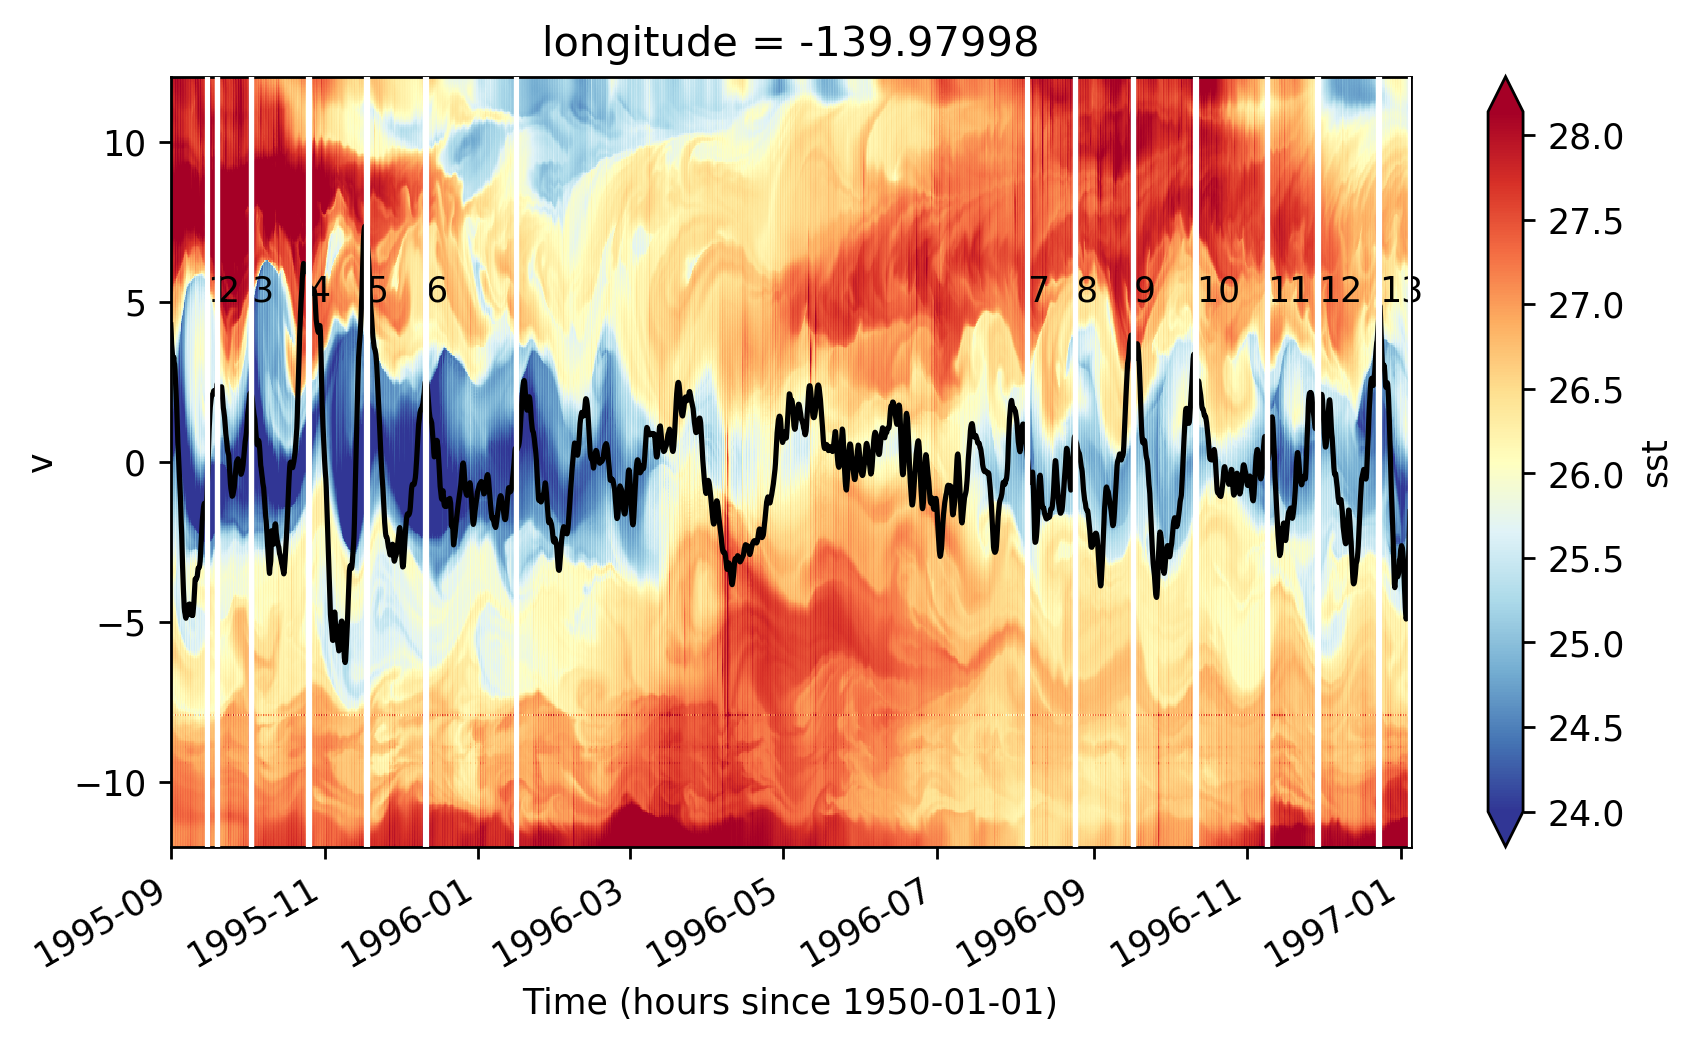

In [ ]:
unique_periods = np.unique(subset.period.dropna('time'))

subset.sst.plot(x='time', cmap=mpl.cm.RdYlBu_r, robust=True)
(10*subset.v.sel(depth=slice(-10, -80)).mean('depth')).plot(x='time', color='k')
plt.gcf().set_size_inches((8, 4))
for period in unique_periods:
    tstart = subset.time.where(subset.period == period, drop=True)[0].values
    tstop = subset.time.where(subset.period == period, drop=True)[-1].values
    plt.text(tstart, 5, f"{period:.0f}")
    plt.gca().axvline(tstart, color='w', zorder=11)
    plt.gca().axvline(tstop, color='w', zorder=11)

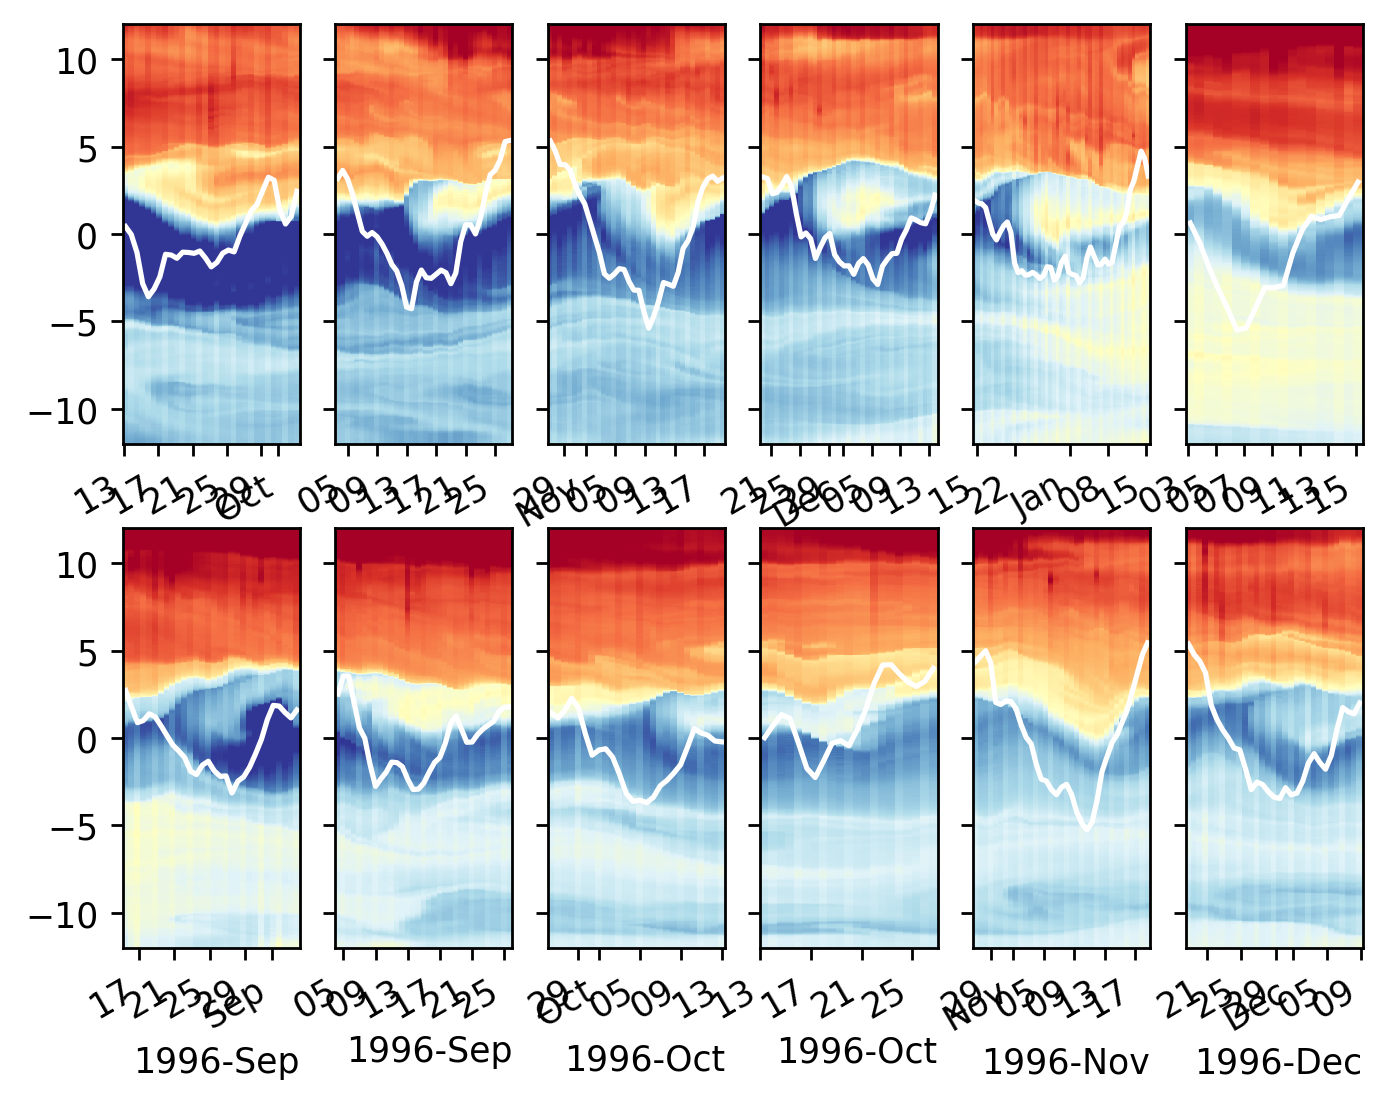

In [ ]:
f, axx = plt.subplots(2, int(unique_periods[-1]/2), sharex=False, sharey=True)

for ax, period in zip(axx.flat, unique_periods):
    extract = subset.where(subset.period==period, drop=True).isel(time=slice(None, None, 4))
    extract.sst.plot(x='time', cmap=mpl.cm.RdYlBu_r, ax=ax, vmin=22, vmax=28, add_colorbar=False, add_labels=False)
    (10*extract.v).sel(depth=slice(-10, -80)).mean('depth').plot(x='time', color='w', ax=ax, _labels=False)
    set_concise_dates(ax)

In [ ]:
subset.where(subset.period == 3, drop=True)

<xarray.Dataset>
Dimensions:          (depth: 284, latitude: 480, time: 142)
Coordinates:
  * depth            (depth) float32 -0.5 -1.5 -2.5 ... -458.8152 -479.7476
  * time             (time) datetime64[ns] 1995-10-27T04:00:00 ... 1995-11-19T16:00:00
    period           (time) float32 3.0 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0 3.0
  * latitude         (latitude) float32 -12.0 -11.949896 ... 11.949896 12.0
    longitude        float32 -110.01001
Data variables:
    TOTTTEND         (time, depth) float32 -0.54420483 -0.5523925 ... 0.12244148
    ADVx_TH          (time, depth) float32 -21074.77 -20604.588 ... -25493.758
    ADVy_TH          (time, depth) float32 94157.875 93187.72 ... 67250.484
    ADVr_TH          (time, depth) float32 nan -315.97177 ... -26401.91
    DFrI_TH          (time, depth) float32 nan -182.46599 ... -3.7077808
    KPPg_TH          (time, depth) float32 nan 606.1816 842.8575 ... nan nan nan
    WTHMASS          (time, depth) float32 -7.626157e-07 ... -0.000856105

In [ ]:
gcm1.plot_tiw_summary(subset.where(subset.period == 4, drop=True).rename({'latitude': 'sst_lat'}), x='time')